# Introduction to Text Analysis in Python

I am not an NLP person and this is outside of my expertise, but I know enough to give a basic introduction to text analysis and text processing tools.

For this tutorial + homework, I'm going to use data from Reddit. I retrieved it from PushShift, using the following code. Unfortunately, Pushshift is not currently available for researchers so this code won't work and you'll just have to grab the version of the data that I've linked to below.

In [32]:
import requests
from datetime import datetime
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from bertopic import BERTopic

```python
## Code used to create the dataset - no longer works

endpt = 'https://api.pushshift.io/reddit/search/submission'

subreddits = ['Coronavirus', 'politics', 'aww']

# Start and end date (pushshift expects these in epoch time)
start_date = int(datetime.strptime('2021-09-11', '%Y-%m-%d').timestamp())
end_date = int(datetime.strptime('2021-09-25', '%Y-%m-%d').timestamp())


def get_posts(subreddit, before = end_date, after = start_date, result = None,  min_comments = 20):
    params = {'subreddit': subreddit,
              'num_comments': f'>{min_comments}',
              'before': before,
              'size': 500
             }
    if result == None:
        result = []
    r = requests.get(endpt, params=params)
    print(r.url)
    print(datetime.fromtimestamp(before))
    for item in r.json()['data']:
        created_time = item['created_utc']
        if created_time < after: # If we've reached the earliest we want, then return
            print(len(result))
            return result
        else:
            try:
                result.append((item['title'],item['selftext'], created_time, subreddit))
            except KeyError:
                print(item)
    time.sleep(.5)
    return get_posts(subreddit, before = created_time, result = result)


sr_data = []
for subreddit in subreddits:
    new_data = get_posts(subreddit)
    sr_data = sr_data + new_data
sr = pd.DataFrame(sr_data, columns = ['title', 'selftext', 'date', 'subreddit'])
sr.date = pd.to_datetime(sr.date, unit='s')
sr.to_csv('./sr_post_data.csv', index = False)
```

In [4]:
## Code to download and import the file (DO run this code)
sr = pd.read_c('http://jeremydfoote.com/Intro-to-Programming-and-Data-Science/resources/data/sr_post_data.csv')

In [5]:
# Change the date to a datetime, and put it in the index
sr.index = pd.to_datetime(sr.date)

In [6]:
sr.head()

,title,selftext,date,subreddit
date,,,,
2021-09-25 03:59:39,"FALSE: US records 12,366 deaths due to COVID-1...",NaN,2021-09-25 03:59:39,Coronavirus
2021-09-25 03:55:12,Researchers who developed the mRNA technology ...,NaN,2021-09-25 03:55:12,Coronavirus
2021-09-25 02:51:33,The United States Completes Donation of 3.5 mi...,NaN,2021-09-25 02:51:33,Coronavirus
2021-09-25 02:25:46,When will the pandemic end? Models project a d...,NaN,2021-09-25 02:25:46,Coronavirus
2021-09-25 01:55:31,Thousands of teachers may be forced out of NYC...,NaN,2021-09-25 01:55:31,Coronavirus


## Summarization

There are some simple ways to summarize text data that can be useful, without using any special NLP tools.


For example, it can be very interesting to see how the frequency of a term changes over time:

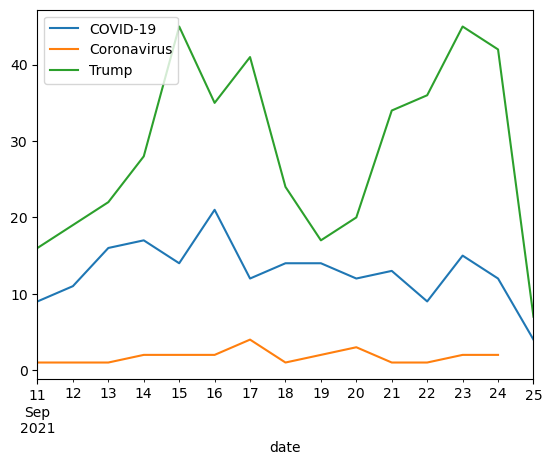

In [7]:
# This code plots the frequency of "COVID-19", "Coronavirus", and "Trump" each day

for term in ["COVID-19", "Coronavirus", "Trump"]:
    curr_df = sr.loc[sr.title.str.contains(term) | sr.selftext.str.contains(term)]
    posts_per_day = curr_df.resample('D').size()
    posts_per_day.plot(label = term)

plt.legend()
plt.show()

### EXERCISE 1

Modify the code above to plot how often "Coronavirus" is used in each of the three subreddits over time

In [6]:
#### YOUR CODE HERE


A similar approach is dictionary-based. The most well-known version of this is [LIWC](http://liwc.wpengine.com/), but the basic idea is that you create a set of words that are associated with a construct you are interested in, and you count how often they appear.

This is a very simple example of how you might do this to look for gendered words among our subreddits

In [8]:
# First we change NAs and removed/deleted to empty strings
sr.loc[(pd.isna(sr.selftext)) | (sr.selftext.isin(['[removed]', '[deleted]'])), 'selftext'] = ''
sr['all_text'] = sr.title + ' ' + sr.selftext

In [13]:
male_words = ['he', 'his']
female_words = ['she', 'hers']

# This puts all of the text of each subreddit into lists
def string_to_list(x):
    return ' '.join(x).split()
grouped_text = sr.groupby('subreddit').all_text.apply(string_to_list)

# Then, we count how often each type of words appears in each subreddit
agg = grouped_text.transform({'proportionMale': lambda x: sum([x.count(y) for y in male_words])/len(x),
                        'proportionFemale': lambda x: sum([x.count(y) for y in female_words])/len(x)}
                        )

In [14]:
grouped_text

subreddit
Coronavirus    [FALSE:, US, records, 12,366, deaths, due, to,...
aww            [This, little, guy, (girl), snuck, into, my, o...
politics       [CNN, Expert, Claims, Black, Voters, Don’t, Ha...
Name: all_text, dtype: object

In [15]:
agg

,proportionMale,proportionFemale
subreddit,,
Coronavirus,0.001874,0.000234
aww,0.011129,0.003251
politics,0.003950,0.000525


### EXERCISE 2

One of the trickiest parts of analysis is getting the data in the form that you want it in order to analyze/visualize it. 

I think a good visualization for this would be a barplot showing how often male and female word types appear for each subreddit. I'll give you the final call to produce the plot:

`sns.barplot(x='subreddit', y='proportion', hue = 'word_gender', data = agg_df_long)`

Now, see if you can get the data in shape so that this code actually works! :)

*Hint: You'll want to use [wide to long](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.wide_to_long.html)*

In [16]:
## Example of how wide_to_long works (from https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.wide_to_long.html)

import numpy as np
np.random.seed(0)

df = pd.DataFrame({'A(weekly)-2010': np.random.rand(3),
                   'A(weekly)-2011': np.random.rand(3),
                   'B(weekly)-2010': np.random.rand(3),
                   'B(weekly)-2011': np.random.rand(3),
                   'X' : np.random.randint(3, size=3)})
df['id'] = df.index
df 

,A(weekly)-2010,A(weekly)-2011,B(weekly)-2010,B(weekly)-2011,X,id
0,0.548814,0.544883,0.437587,0.383442,0,0
1,0.715189,0.423655,0.891773,0.791725,1,1
2,0.602763,0.645894,0.963663,0.528895,1,2


In [17]:
pd.wide_to_long(df, # The data
                # The prefixes for the data columns. These will become column names that hold data values.
                stubnames = ['A(weekly)', 'B(weekly)'], 
                # i is a column which uniquely identifies each row
                i='id',
                # j is what you want to call the prefix
                j='year',
                # sep is a string that is between the stubnames and the values which will go in j
                sep='-')

,,X,A(weekly),B(weekly)
id,year,,,
0,2010,0,0.548814,0.437587
1,2010,1,0.715189,0.891773
2,2010,1,0.602763,0.963663
0,2011,0,0.544883,0.383442
1,2011,1,0.423655,0.791725
2,2011,1,0.645894,0.528895


In [18]:
## Exercise 2 Code
## This code will get the df ready for pd.wide_to_long (try printing agg_df after running these to see what it looks like)
agg_df = agg.unstack(level=0)
agg_df = agg_df.reset_index()

### Your code here

In [19]:
agg_df

,level_0,subreddit,0
0,proportionMale,Coronavirus,0.001874
1,proportionMale,aww,0.011129
2,proportionMale,politics,0.003950
3,proportionFemale,Coronavirus,0.000234
4,proportionFemale,aww,0.003251
5,proportionFemale,politics,0.000525


In [15]:
## Once you've created agg_df_long with the columns proportion and word_gender, you should be able to run this
sns.barplot(x='subreddit', y='proportion', hue = 'word_gender', data = agg_df_long)

NameError: name 'agg_df_long' is not defined

### EXERCISE 3

Make your own analysis, with a different set of terms

## TF-IDF

There are more complicated approaches to summarization in Python, including using LIWC (see [here](https://pypi.org/project/liwc/)).

Almost all approaches are based on a "bag of words" approach, where the order of words is totally ignored. This is obviously a big simplification, but can often work quite well.

One thing we might want to do is to differentiate groups of texts based on how often words are used. The naive way is to just count how often words appear. However, the most common words will always appear first. So, computational linguists came up with "term frequency--inverse document frequency" (TF-IDF). This normalizes words based on how often they appear across groups of texts. A detailed explanation with code is [here](https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76).

There are a number of NLP / text analysis libraries in Python. The one I'm most familiar with is scikit-learn, which is a machine learning library. NLTK, SpaCy, and textblob are some of the most popular. Here is how to run TF-IDF in scikit-learn.

In [20]:
## First, we prepare the data for the TF-IDF tool.
# We want each subreddit to be represented by a list of strings.
# So, we take our grouped_text (which is a list of lists of words)
# and change it into a list of three really long strings, where each
# string is all the words that appeared for that subreddit.

# This called a 'list comprehension'
as_text = [' '.join(x) for x in grouped_text]

# It is equivalent to the following for loop
as_text = []
for x in grouped_text:
    as_text.append(' '.join(x))

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Just gets the 5000 most common words
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

tfidf_result = vectorizer.fit_transform(as_text)
feature_names = vectorizer.get_feature_names_out()
dense = tfidf_result.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose()
df.columns = list(grouped_text.index)

In [22]:
# This shows the values with the highest TF-IDF for r/Coronavirus
df.sort_values('aww', ascending=False).head(20)

,Coronavirus,aww,politics
cat,0.000000,0.409908,0.000000
dog,0.000000,0.286604,0.000858
little,0.000000,0.266492,0.003431
just,0.006542,0.206955,0.031306
cute,0.000000,0.171897,0.000000
girl,0.000000,0.171897,0.000000
baby,0.001308,0.171811,0.000666
new,0.056262,0.171811,0.106574
today,0.000000,0.145816,0.001715
puppy,0.000000,0.145451,0.000000


## Relative frequency


An even simpler approach that works pretty well when comparing just two "documents" is to rank how much more often a word appears in one rather than the other.


In [23]:
politics_str = ' '.join(sr.loc[sr.subreddit == 'politics', 'all_text']).lower()
covid_str = ' '.join(sr.loc[sr.subreddit == 'Coronavirus', 'all_text']).lower()

In [24]:
def word_ratios(text):
    counts = {}
    tot_words = 0
    for word in text.split():
        counts[word] = counts.get(word, 0) + 1
        tot_words +=1
    result = {}
    for word, count in counts.items():
        result[word] = count/tot_words
    return result
    
    
politics_ratio = word_ratios(politics_str)
covid_ratio = word_ratios(covid_str)

In [25]:
ratio_diff = []
for word in politics_ratio:
    if word in covid_ratio:
        ratio_diff.append((word, politics_ratio[word] - covid_ratio[word]))

In [26]:
ratio_diff = sorted(ratio_diff, key = lambda x: x[1])

Here are the words that appear more often in r/Coronavirus

In [27]:
ratio_diff[:15]

[('covid-19', -0.020888477566596217),
 ('covid', -0.012544929169800238),
 ('vaccine', -0.00592151224450452),
 ('more', -0.005169286900006672),
 ('information', -0.004752876614738616),
 ('our', -0.004724119177071341),
 ('for', -0.004715598694414918),
 ('vaccination', -0.004380547049728374),
 ('are', -0.003921754318080493),
 ('in', -0.003903396786161282),
 ('health', -0.0037529976515266027),
 ('of', -0.0036447707007916177),
 ('there', -0.0033541814836345095),
 ('vaccines', -0.0031055833011634434),
 ('cases', -0.0030923399997225182)]

And here are those that appear more often in r/politics.

In [28]:
ratio_diff[-15:][::-1] # The [::-1] just reverses the list

[('biden', 0.008418094533021217),
 ('to', 0.0066828403369883875),
 ('the', 0.004575618874372623),
 ('texas', 0.0032892912474584077),
 ('bill', 0.0030318005794814544),
 ('on', 0.0030221543838544786),
 ('a', 0.002709801382600024),
 ('that', 0.002206546223422705),
 ('court', 0.0021136522597004167),
 ('law', 0.001782188016405662),
 ('his', 0.0016662137019796605),
 ('was', 0.0016506995657533103),
 ('from', 0.00162875463244231),
 ('calls', 0.0016230775454787474),
 ('white', 0.001588833874483722)]

## Classification

Another commonly-used tool in NLP is classification. This is a "supervised machine learning" model, where you build a "training set" of items that are classified, and a machine learner uses that set to predict the classification of new items.

One very common example is sentiment. In sentiment analysis, a random set of texts is manually classified as positive, neutral, or negative. This set is then used to train a classifier to predict the sentiment of unseen texts.

It's beyond the scope of this class to learn how to do machine learning, but there are also pre-trained classifiers. One I found is from [textblob](https://textblob.readthedocs.io/en/dev/).

NLTK also has a pre-trained classifier, trained on social media data, called VADER. That is pretty similar to what we're looking at, so this example shows how to use it.

NLTK is interesting - the core is installed in Anaconda, so you should have it. However, to get various pieces to work you need to install them. So, we need to start by installing the vader lexicon.

In [29]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jeremy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(sentence):
    vs = analyzer.polarity_scores(sentence)
    return vs['compound']

sr['sentiment'] = sr.all_text.apply(get_sentiment)

In [31]:
sr.sort_values('sentiment', ascending=False).head()

,title,selftext,date,subreddit,all_text,sentiment
date,,,,,,
2021-09-24 15:18:15,We’re the League of Women Voters! We launched ...,Hi! We’re activists and experts from the Leagu...,2021-09-24 15:18:15,politics,We’re the League of Women Voters! We launched ...,0.9822
2021-09-20 17:37:13,"The ""What happened in your state last week?"" M...",Welcome to the 'What happened in your state la...,2021-09-20 17:37:13,politics,"The ""What happened in your state last week?"" M...",0.9671
2021-09-13 16:08:17,"The ""What happened in your state last week?"" M...",Welcome to the 'What happened in your state la...,2021-09-13 16:08:17,politics,"The ""What happened in your state last week?"" M...",0.9671
2021-09-17 16:05:41,Free Chat Friday Thread,It's finally Friday! That means it's time to s...,2021-09-17 16:05:41,politics,Free Chat Friday Thread It's finally Friday! T...,0.9650
2021-09-14 02:54:07,Hello I know I'm different but my beautiful he...,,2021-09-14 02:54:07,aww,Hello I know I'm different but my beautiful he...,0.9587
